<a href="https://colab.research.google.com/github/CloudyBuaaer/transformer/blob/main/site/zh-cn/tutorials/text/transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 理解语言的 Transformer 模型

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://tensorflow.google.cn/tutorials/text/transformer">
    <img src="https://tensorflow.google.cn/images/tf_logo_32px.png" />
    在 tensorflow.google.cn 上查看</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/text/transformer.ipynb">
    <img src="https://tensorflow.google.cn/images/colab_logo_32px.png" />
    在 Google Colab 运行</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/text/transformer.ipynb">
    <img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png" />
    在 Github 上查看源代码</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/tutorials/text/transformer.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png" />下载此 notebook</a>
  </td>
</table>

Note: 我们的 TensorFlow 社区翻译了这些文档。因为社区翻译是尽力而为， 所以无法保证它们是最准确的，并且反映了最新的
[官方英文文档](https://tensorflow.google.cn/?hl=en)。如果您有改进此翻译的建议， 请提交 pull request 到
[tensorflow/docs](https://github.com/tensorflow/docs) GitHub 仓库。要志愿地撰写或者审核译文，请加入
[docs-zh-cn@tensorflow.org Google Group](https://groups.google.com/a/tensorflow.org/forum/#!forum/docs-zh-cn)

本教程训练了一个 <a href="https://arxiv.org/abs/1706.03762" class="external">Transformer 模型</a> 用于将葡萄牙语翻译成英语。这是一个高级示例，假定您具备[文本生成（text generation）](text_generation.ipynb)和 [注意力机制（attention）](nmt_with_attention.ipynb) 的知识。

Transformer 模型的核心思想是*自注意力机制（self-attention）*——能注意输入序列的不同位置以计算该序列的表示的能力。Transformer 创建了多层自注意力层（self-attetion layers）组成的堆栈，下文的*按比缩放的点积注意力（Scaled dot product attention）*和*多头注意力（Multi-head attention）*部分对此进行了说明。

一个 transformer 模型用自注意力层而非 [RNNs](text_classification_rnn.ipynb) 或 [CNNs](../images/intro_to_cnns.ipynb) 来处理变长的输入。这种通用架构有一系列的优势：

* 它不对数据间的时间/空间关系做任何假设。这是处理一组对象（objects）的理想选择（例如，[星际争霸单位（StarCraft units）](https://www.deepmind.com/blog/alphastar-mastering-the-real-time-strategy-game-starcraft-ii)）。
* 层输出可以并行计算，而非像 RNN 这样的序列计算。
* 远距离项可以影响彼此的输出，而无需经过许多 RNN 步骤或卷积层（例如，参见[场景记忆 Transformer（Scene Memory Transformer）](https://arxiv.org/pdf/1903.03878.pdf)）
* 它能学习长距离的依赖。在许多序列任务中，这是一项挑战。

该架构的缺点是：

* 对于时间序列，一个单位时间的输出是从*整个历史记录*计算的，而非仅从输入和当前的隐含状态计算得到。这*可能*效率较低。   
* 如果输入*确实*有时间/空间的关系，像文本，则必须加入一些位置编码，否则模型将有效地看到一堆单词。

在此 notebook 中训练完模型后，您将能输入葡萄牙语句子，得到其英文翻译。

<img src="https://tensorflow.google.cn/images/tutorials/transformer/attention_map_portuguese.png" width="800" alt="Attention heatmap">

In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf

import time
import numpy as np
import matplotlib.pyplot as plt

## 设置输入流水线（input pipeline）

使用 [TFDS](https://tensorflow.google.cn/datasets) 来导入 [葡萄牙语-英语翻译数据集](https://github.com/neulab/word-embeddings-for-nmt)，该数据集来自于 [TED 演讲开放翻译项目](https://www.ted.com/participate/translate).

该数据集包含来约 50000 条训练样本，1100 条验证样本，以及 2000 条测试样本。

In [3]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
                               as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

# print(metadata)
# for pt_text, en_text in train_examples.take(3):
#     print("Portuguese:", pt_text.numpy())
#     print("English:", en_text.numpy())

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/incomplete.RQ0YAF_1.0.0/ted_hrlr_translate-tra…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/incomplete.RQ0YAF_1.0.0/ted_hrlr_translate-val…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/incomplete.RQ0YAF_1.0.0/ted_hrlr_translate-tes…

Dataset ted_hrlr_translate downloaded and prepared to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.


从训练数据集创建自定义子词分词器（subwords tokenizer）。

In [4]:
tokenizer_en = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for pt, en in train_examples), target_vocab_size=2**13)

tokenizer_pt = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (pt.numpy() for pt, en in train_examples), target_vocab_size=2**13)

In [5]:
sample_string = 'Transformer is awesome.'

tokenized_string = tokenizer_en.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

# for token_id in tokenized_string:
#     token_text = tokenizer_en.decode([token_id])
#     print(f'Token ID {token_id} → "{token_text}"')

original_string = tokenizer_en.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

assert original_string == sample_string


# sample_string2 = 'I am interested in large language model and Reinforcement learning.'

# tokenized_string2 = tokenizer_en.encode(sample_string2)
# print ('Tokenized string is {}'.format(tokenized_string2))

# for token_id in tokenized_string2:
#     token_text2 = tokenizer_en.decode([token_id])
#     print(f'Token ID {token_id} → "{token_text2}"')

# original_string2 = tokenizer_en.decode(tokenized_string2)
# print ('The original string: {}'.format(original_string2))

# assert original_string2 == sample_string2

Tokenized string is [7915, 1248, 7946, 7194, 13, 2799, 7877]
The original string: Transformer is awesome.


如果单词不在词典中，则分词器（tokenizer）通过将单词分解为子词来对字符串进行编码。

In [6]:
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer_en.decode([ts])))

7915 ----> T
1248 ----> ran
7946 ----> s
7194 ----> former 
13 ----> is 
2799 ----> awesome
7877 ----> .


In [7]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

将开始和结束标记（token）添加到输入和目标。

In [8]:
def encode(lang1, lang2):
  lang1 = [tokenizer_pt.vocab_size] + tokenizer_pt.encode(
      lang1.numpy()) + [tokenizer_pt.vocab_size+1]

  lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(
      lang2.numpy()) + [tokenizer_en.vocab_size+1]

  return lang1, lang2

Note：为了使本示例较小且相对较快，删除长度大于40个标记的样本。

In [9]:
MAX_LENGTH = 40

In [10]:
def filter_max_length(x, y, max_length=MAX_LENGTH):
  return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)

`.map()` 内部的操作以图模式（graph mode）运行，`.map()` 接收一个不具有 numpy 属性的图张量（graph tensor）。该`分词器（tokenizer）`需要将一个字符串或 Unicode 符号，编码成整数。因此，您需要在 `tf.py_function` 内部运行编码过程，`tf.py_function` 接收一个 eager 张量，该 eager 张量有一个包含字符串值的 numpy 属性。

In [11]:
def tf_encode(pt, en):
  result_pt, result_en = tf.py_function(encode, [pt, en], [tf.int64, tf.int64])
  result_pt.set_shape([None])
  result_en.set_shape([None])

  return result_pt, result_en

In [12]:
train_dataset = train_examples.map(tf_encode)
train_dataset = train_dataset.filter(filter_max_length)
# 将数据集缓存到内存中以加快读取速度。
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)


val_dataset = val_examples.map(tf_encode)
val_dataset = val_dataset.filter(filter_max_length).padded_batch(BATCH_SIZE)

In [13]:
pt_batch, en_batch = next(iter(val_dataset))
pt_batch, en_batch

(<tf.Tensor: shape=(64, 38), dtype=int64, numpy=
 array([[8214,  342, 3032, ...,    0,    0,    0],
        [8214,   95,  198, ...,    0,    0,    0],
        [8214, 4479, 7990, ...,    0,    0,    0],
        ...,
        [8214,  584,   12, ...,    0,    0,    0],
        [8214,   59, 1548, ...,    0,    0,    0],
        [8214,  118,   34, ...,    0,    0,    0]])>,
 <tf.Tensor: shape=(64, 40), dtype=int64, numpy=
 array([[8087,   98,   25, ...,    0,    0,    0],
        [8087,   12,   20, ...,    0,    0,    0],
        [8087,   12, 5453, ...,    0,    0,    0],
        ...,
        [8087,   18, 2059, ...,    0,    0,    0],
        [8087,   16, 1436, ...,    0,    0,    0],
        [8087,   15,   57, ...,    0,    0,    0]])>)

## 位置编码（Positional encoding）

因为该模型并不包括任何的循环（recurrence）或卷积，所以模型添加了位置编码，为模型提供一些关于单词在句子中相对位置的信息。

位置编码向量被加到嵌入（embedding）向量中。嵌入表示一个 d 维空间的标记，在 d 维空间中有着相似含义的标记会离彼此更近。但是，嵌入并没有对在一句话中的词的相对位置进行编码。因此，当加上位置编码后，词将基于*它们含义的相似度以及它们在句子中的位置*，在 d 维空间中离彼此更近。

参看 [位置编码](https://github.com/tensorflow/examples/blob/master/community/en/position_encoding.ipynb) 的 notebook 了解更多信息。计算位置编码的公式如下：

$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

In [14]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [15]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # 将 sin 应用于数组中的偶数索引（indices）；2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # 将 cos 应用于数组中的奇数索引；2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


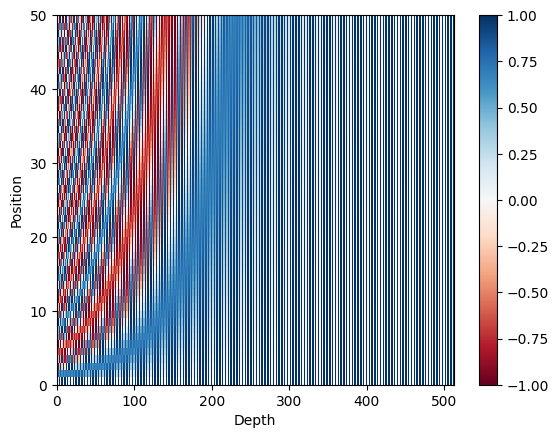

In [16]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## 遮挡（Masking）

遮挡一批序列中所有的填充标记（pad tokens）。这确保了模型不会将填充作为输入。该 mask 表明填充值 `0` 出现的位置：在这些位置 mask 输出 `1`，否则输出 `0`。

In [17]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

  # 添加额外的维度来将填充加到
  # 注意力对数（logits）。
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [18]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

前瞻遮挡（look-ahead mask）用于遮挡一个序列中的后续标记（future tokens）。换句话说，该 mask 表明了不应该使用的条目。

这意味着要预测第三个词，将仅使用第一个和第二个词。与此类似，预测第四个词，仅使用第一个，第二个和第三个词，依此类推。

In [19]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [20]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

## 按比缩放的点积注意力（Scaled dot product attention）

<img src="https://tensorflow.google.cn/images/tutorials/transformer/scaled_attention.png" width="500" alt="scaled_dot_product_attention">

Transformer 使用的注意力函数有三个输入：Q（请求（query））、K（主键（key））、V（数值（value））。用于计算注意力权重的等式为：

$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

点积注意力被缩小了深度的平方根倍。这样做是因为对于较大的深度值，点积的大小会增大，从而推动 softmax 函数往仅有很小的梯度的方向靠拢，导致了一种很硬的（hard）softmax。

例如，假设 `Q` 和 `K` 的均值为0，方差为1。它们的矩阵乘积将有均值为0，方差为 `dk`。因此，*`dk` 的平方根*被用于缩放（而非其他数值），因为，`Q` 和 `K` 的矩阵乘积的均值本应该为 0，方差本应该为1，这样会获得一个更平缓的 softmax。

遮挡（mask）与 -1e9（接近于负无穷）相乘。这样做是因为遮挡与缩放的 Q 和 K 的矩阵乘积相加，并在 softmax 之前立即应用。目标是将这些单元归零，因为 softmax 的较大负数输入在输出中接近于零。

In [21]:
def scaled_dot_product_attention(q, k, v, mask):
  """计算注意力权重。
  q, k, v 必须具有匹配的前置维度。
  k, v 必须有匹配的倒数第二个维度，例如：seq_len_k = seq_len_v。
  虽然 mask 根据其类型（填充或前瞻）有不同的形状，
  但是 mask 必须能进行广播转换以便求和。

  参数:
    q: 请求的形状 == (..., seq_len_q, depth)
    k: 主键的形状 == (..., seq_len_k, depth)
    v: 数值的形状 == (..., seq_len_v, depth_v)
    mask: Float 张量，其形状能转换成
          (..., seq_len_q, seq_len_k)。默认为None。

  返回值:
    输出，注意力权重
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

  # 缩放 matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # 将 mask 加入到缩放的张量上。
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)

  # softmax 在最后一个轴（seq_len_k）上归一化，因此分数
  # 相加等于1。
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

当 softmax 在 K 上进行归一化后，它的值决定了分配到 Q 的重要程度。

输出表示注意力权重和 V（数值）向量的乘积。这确保了要关注的词保持原样，而无关的词将被清除掉。

In [22]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print ('Attention weights are:')
  print (temp_attn)
  print ('Output is:')
  print (temp_out)

In [23]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# 这条 `请求（query）符合第二个`主键（key）`，
# 因此返回了第二个`数值（value）`。
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [24]:
# 这条请求符合重复出现的主键（第三第四个），
# 因此，对所有的相关数值取了平均。
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [25]:
# 这条请求符合第一和第二条主键，
# 因此，对它们的数值去了平均。
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


将所有请求一起*传递*。

In [26]:
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


## 多头注意力（Multi-head attention）

<img src="https://tensorflow.google.cn/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">


多头注意力由四部分组成：
*    线性层并分拆成多头。
*    按比缩放的点积注意力。
*    多头及联。
*    最后一层线性层。

每个多头注意力块有三个输入：Q（请求）、K（主键）、V（数值）。这些输入经过线性（Dense）层，并分拆成多头。

将上面定义的 `scaled_dot_product_attention` 函数应用于每个头（进行了广播（broadcasted）以提高效率）。注意力这步必须使用一个恰当的 mask。然后将每个头的注意力输出连接起来（用`tf.transpose` 和 `tf.reshape`），并放入最后的 `Dense` 层。

Q、K、和 V 被拆分到了多个头，而非单个的注意力头，因为多头允许模型共同注意来自不同表示空间的不同位置的信息。在分拆后，每个头部的维度减少，因此总的计算成本与有着全部维度的单个注意力头相同。

In [27]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    """分拆最后一个维度到 (num_heads, depth).
    转置结果使得形状为 (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

    return output, attention_weights

创建一个 `MultiHeadAttention` 层进行尝试。在序列中的每个位置 `y`，`MultiHeadAttention` 在序列中的所有其他位置运行所有8个注意力头，在每个位置y，返回一个新的同样长度的向量。

In [28]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

## 点式前馈网络（Point wise feed forward network）

点式前馈网络由两层全联接层组成，两层之间有一个 ReLU 激活函数。

In [29]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [30]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

## 编码与解码（Encoder and decoder）

<img src="https://tensorflow.google.cn/images/tutorials/transformer/transformer.png" width="600" alt="transformer">

Transformer 模型与标准的[具有注意力机制的序列到序列模型（sequence to sequence with attention model）](nmt_with_attention.ipynb)，遵循相同的一般模式。

* 输入语句经过 `N` 个编码器层，为序列中的每个词/标记生成一个输出。
* 解码器关注编码器的输出以及它自身的输入（自注意力）来预测下一个词。

### 编码器层（Encoder layer）

每个编码器层包括以下子层：

1.   多头注意力（有填充遮挡）
2.   点式前馈网络（Point wise feed forward networks）。

每个子层在其周围有一个残差连接，然后进行层归一化。残差连接有助于避免深度网络中的梯度消失问题。

每个子层的输出是 `LayerNorm(x + Sublayer(x))`。归一化是在 `d_model`（最后一个）维度完成的。Transformer 中有 N 个编码器层。

In [31]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

    return out2

In [32]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), training=False, mask=None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

### 解码器层（Decoder layer）

每个解码器层包括以下子层：

1.   遮挡的多头注意力（前瞻遮挡和填充遮挡）
2.   多头注意力（用填充遮挡）。V（数值）和 K（主键）接收*编码器输出*作为输入。Q（请求）接收*遮挡的多头注意力子层的输出*。
3.   点式前馈网络

每个子层在其周围有一个残差连接，然后进行层归一化。每个子层的输出是 `LayerNorm(x + Sublayer(x))`。归一化是在 `d_model`（最后一个）维度完成的。

Transformer 中共有 N 个解码器层。

当 Q 接收到解码器的第一个注意力块的输出，并且 K 接收到编码器的输出时，注意力权重表示根据编码器的输出赋予解码器输入的重要性。换一种说法，解码器通过查看编码器输出和对其自身输出的自注意力，预测下一个词。参看按比缩放的点积注意力部分的演示。

In [33]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)


  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)

    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

    return out3, attn_weights_block1, attn_weights_block2

In [34]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, attn_weights_block1, attn_weights_block2 = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output,
    training=False, look_ahead_mask=None, padding_mask=None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

### 编码器（Encoder）

`编码器` 包括：
1.   输入嵌入（Input Embedding）
2.   位置编码（Positional Encoding）
3.   N 个编码器层（encoder layers）

输入经过嵌入（embedding）后，该嵌入与位置编码相加。该加法结果的输出是编码器层的输入。编码器的输出是解码器的输入。

In [35]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding,
                                            self.d_model)


    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                       for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]

    # 将嵌入和位置编码相加。
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training=training, mask=mask)

    return x  # (batch_size, input_seq_len, d_model)

In [36]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)

sample_encoder_output = sample_encoder(tf.random.uniform((64, 62)), training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


### 解码器（Decoder）

`解码器`包括：
1.   输出嵌入（Output Embedding）
2.   位置编码（Positional Encoding）
3.   N 个解码器层（decoder layers）

目标（target）经过一个嵌入后，该嵌入和位置编码相加。该加法结果是解码器层的输入。解码器的输出是最后的线性层的输入。

In [37]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}

    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output=enc_output, training=training,
                                             look_ahead_mask=look_ahead_mask, padding_mask=padding_mask)

      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [38]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)

output, attn = sample_decoder(tf.random.uniform((64, 26)),
                              enc_output=sample_encoder_output,
                              training=False, look_ahead_mask=None,
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

## 创建 Transformer

Transformer 包括编码器，解码器和最后的线性层。解码器的输出是线性层的输入，返回线性层的输出。

In [61]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                           input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inp, tar, training, enc_padding_mask,
           look_ahead_mask, dec_padding_mask):

    enc_output = self.encoder(inp, training=training, mask=enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training=training, look_ahead_mask=look_ahead_mask, padding_mask=dec_padding_mask)

    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

    return final_output, attention_weights

In [63]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048,
    input_vocab_size=8500, target_vocab_size=8000,
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 62))
temp_target = tf.random.uniform((64, 26))

fn_out, _ = sample_transformer(inp=temp_input, tar=temp_target, training=False,
                               enc_padding_mask=None,
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)
print(fn_out[0, 0, :])

tf.Tensor(
[ 0.4939663  -0.12397037  0.21253242 ... -0.15399425 -0.19302528
 -0.02966643], shape=(8000,), dtype=float32)


## 配置超参数（hyperparameters）

为了让本示例小且相对较快，已经减小了*num_layers、 d_model 和  dff* 的值。

Transformer 的基础模型使用的数值为：*num_layers=6*，*d_model = 512*，*dff = 2048*。关于所有其他版本的 Transformer，请查阅[论文](https://arxiv.org/abs/1706.03762)。

Note：通过改变以下数值，您可以获得在许多任务上达到最先进水平的模型。

In [64]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_pt.vocab_size + 2
target_vocab_size = tokenizer_en.vocab_size + 2
dropout_rate = 0.1

## 优化器（Optimizer）

根据[论文](https://arxiv.org/abs/1706.03762)中的公式，将 Adam 优化器与自定义的学习速率调度程序（scheduler）配合使用。

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$


In [82]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(tf.cast(step, tf.float32))
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [83]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

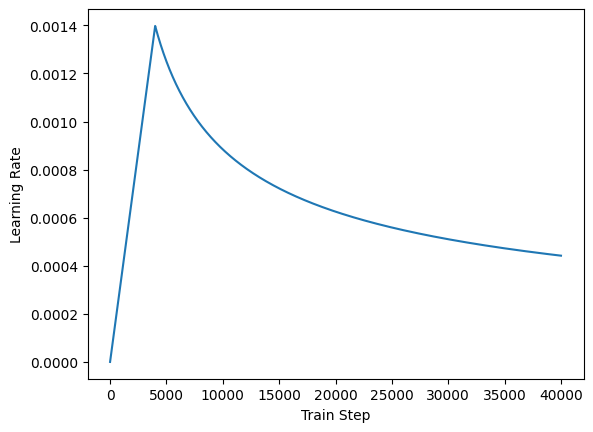

In [84]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## 损失函数与指标（Loss and metrics）

由于目标序列是填充（padded）过的，因此在计算损失函数时，应用填充遮挡非常重要。

In [85]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [86]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [87]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

## 训练与检查点（Training and checkpointing）

In [88]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size,
                          pe_input=input_vocab_size,
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [89]:
def create_masks(inp, tar):
  # 编码器填充遮挡
  enc_padding_mask = create_padding_mask(inp)

  # 在解码器的第二个注意力模块使用。
  # 该填充遮挡用于遮挡编码器的输出。
  dec_padding_mask = create_padding_mask(inp)

  # 在解码器的第一个注意力模块使用。
  # 用于填充（pad）和遮挡（mask）解码器获取到的输入的后续标记（future tokens）。
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

  return enc_padding_mask, combined_mask, dec_padding_mask

创建检查点的路径和检查点管理器（manager）。这将用于在每 `n` 个周期（epochs）保存检查点。

In [90]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# 如果检查点存在，则恢复最新的检查点。
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

目标（target）被分成了 tar_inp 和 tar_real。tar_inp 作为输入传递到解码器。`tar_real` 是位移了 1 的同一个输入：在 `tar_inp` 中的每个位置，`tar_real` 包含了应该被预测到的下一个标记（token）。

例如，`sentence` = "SOS A lion in the jungle is sleeping EOS"

`tar_inp` =  "SOS A lion in the jungle is sleeping"

`tar_real` = "A lion in the jungle is sleeping EOS"

Transformer 是一个自回归（auto-regressive）模型：它一次作一个部分的预测，然后使用到目前为止的自身的输出来决定下一步要做什么。

在训练过程中，本示例使用了 teacher-forcing 的方法（就像[文本生成教程](./text_generation.ipynb)中一样）。无论模型在当前时间步骤下预测出什么，teacher-forcing 方法都会将真实的输出传递到下一个时间步骤上。

当 transformer 预测每个词时，*自注意力（self-attention）*功能使它能够查看输入序列中前面的单词，从而更好地预测下一个单词。

为了防止模型在期望的输出上达到峰值，模型使用了前瞻遮挡（look-ahead mask）。

In [91]:
EPOCHS = 20

In [92]:
# 该 @tf.function 将追踪-编译 train_step 到 TF 图中，以便更快地
# 执行。该函数专用于参数张量的精确形状。为了避免由于可变序列长度或可变
# 批次大小（最后一批次较小）导致的再追踪，使用 input_signature 指定
# 更多的通用形状。

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]

  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp,
                                 training=True,
                                 enc_padding_mask=enc_padding_mask,
                                 look_ahead_mask=combined_mask,
                                 dec_padding_mask=dec_padding_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  train_loss(loss)
  train_accuracy(tar_real, predictions)

葡萄牙语作为输入语言，英语为目标语言。

In [93]:
from tqdm.rich import tqdm
for epoch in tqdm(range(EPOCHS)):
# for epoch in range(EPOCHS):
  start = time.time()

  train_loss.reset_state()
  train_accuracy.reset_state()

  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(train_dataset):
    train_step(inp, tar)

    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1,
                                                train_loss.result(),
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Output()

/tmp/ipython-input-2902282043.py:2: TqdmExperimentalWarning: rich is experimental/alpha
  for epoch in tqdm(range(EPOCHS)):


Epoch 1 Batch 0 Loss 4.1422 Accuracy 0.0000

Epoch 1 Batch 50 Loss 4.2159 Accuracy 0.0005

Epoch 1 Batch 100 Loss 4.1548 Accuracy 0.0125

Epoch 1 Batch 150 Loss 4.1056 Accuracy 0.0171

Epoch 1 Batch 200 Loss 4.0393 Accuracy 0.0211

Epoch 1 Batch 250 Loss 3.9613 Accuracy 0.0263

Epoch 1 Batch 300 Loss 3.8894 Accuracy 0.0302

Epoch 1 Batch 350 Loss 3.8116 Accuracy 0.0331

Epoch 1 Batch 400 Loss 3.7302 Accuracy 0.0352

Epoch 1 Batch 450 Loss 3.6491 Accuracy 0.0375

Epoch 1 Batch 500 Loss 3.5797 Accuracy 0.0404

Epoch 1 Batch 550 Loss 3.5205 Accuracy 0.0440

Epoch 1 Batch 600 Loss 3.4639 Accuracy 0.0475

Epoch 1 Batch 650 Loss 3.4045 Accuracy 0.0510

Epoch 1 Batch 700 Loss 3.3497 Accuracy 0.0546

Epoch 1 Loss 3.3474 Accuracy 0.0547

Time taken for 1 epoch: 156.34616708755493 secs

Epoch 2 Batch 0 Loss 2.4407 Accuracy 0.0912

Epoch 2 Batch 50 Loss 2.5345 Accuracy 0.1034

Epoch 2 Batch 100 Loss 2.5449 Accuracy 0.1074

Epoch 2 Batch 150 Loss 2.5237 Accuracy 0.1103

Epoch 2 Batch 200 Loss 2.4992 Accuracy 0.1121

Epoch 2 Batch 250 Loss 2.4746 Accuracy 0.1137

Epoch 2 Batch 300 Loss 2.4649 Accuracy 0.1154

Epoch 2 Batch 350 Loss 2.4514 Accuracy 0.1170

Epoch 2 Batch 400 Loss 2.4316 Accuracy 0.1184

Epoch 2 Batch 450 Loss 2.4162 Accuracy 0.1200

Epoch 2 Batch 500 Loss 2.4014 Accuracy 0.1213

Epoch 2 Batch 550 Loss 2.3880 Accuracy 0.1225

Epoch 2 Batch 600 Loss 2.3774 Accuracy 0.1237

Epoch 2 Batch 650 Loss 2.3683 Accuracy 0.1250

Epoch 2 Batch 700 Loss 2.3550 Accuracy 0.1259

Epoch 2 Loss 2.3544 Accuracy 0.1260

Time taken for 1 epoch: 81.91441321372986 secs

Epoch 3 Batch 0 Loss 2.1413 Accuracy 0.1451

Epoch 3 Batch 50 Loss 2.1550 Accuracy 0.1434

Epoch 3 Batch 100 Loss 2.1651 Accuracy 0.1446

Epoch 3 Batch 150 Loss 2.1642 Accuracy 0.1454

Epoch 3 Batch 200 Loss 2.1571 Accuracy 0.1462

Epoch 3 Batch 250 Loss 2.1507 Accuracy 0.1468

Epoch 3 Batch 300 Loss 2.1427 Accuracy 0.1469

Epoch 3 Batch 350 Loss 2.1390 Accuracy 0.1478

Epoch 3 Batch 400 Loss 2.1318 Accuracy 0.1482

Epoch 3 Batch 450 Loss 2.1287 Accuracy 0.1488

Epoch 3 Batch 500 Loss 2.1209 Accuracy 0.1493

Epoch 3 Batch 550 Loss 2.1141 Accuracy 0.1500

Epoch 3 Batch 600 Loss 2.1062 Accuracy 0.1504

Epoch 3 Batch 650 Loss 2.1006 Accuracy 0.1511

Epoch 3 Batch 700 Loss 2.0960 Accuracy 0.1519

Epoch 3 Loss 2.0961 Accuracy 0.1520

Time taken for 1 epoch: 59.44480347633362 secs

Epoch 4 Batch 0 Loss 1.9855 Accuracy 0.1489

Epoch 4 Batch 50 Loss 1.9921 Accuracy 0.1674

Epoch 4 Batch 100 Loss 1.9715 Accuracy 0.1671

Epoch 4 Batch 150 Loss 1.9470 Accuracy 0.1669

Epoch 4 Batch 200 Loss 1.9403 Accuracy 0.1679

Epoch 4 Batch 250 Loss 1.9356 Accuracy 0.1690

Epoch 4 Batch 300 Loss 1.9285 Accuracy 0.1698

Epoch 4 Batch 350 Loss 1.9185 Accuracy 0.1706

Epoch 4 Batch 400 Loss 1.9106 Accuracy 0.1714

Epoch 4 Batch 450 Loss 1.9048 Accuracy 0.1726

Epoch 4 Batch 500 Loss 1.8995 Accuracy 0.1736

Epoch 4 Batch 550 Loss 1.8902 Accuracy 0.1744

Epoch 4 Batch 600 Loss 1.8822 Accuracy 0.1753

Epoch 4 Batch 650 Loss 1.8782 Accuracy 0.1766

Epoch 4 Batch 700 Loss 1.8728 Accuracy 0.1777

Epoch 4 Loss 1.8728 Accuracy 0.1777

Time taken for 1 epoch: 61.450815200805664 secs

Epoch 5 Batch 0 Loss 1.7276 Accuracy 0.2078

Epoch 5 Batch 50 Loss 1.7288 Accuracy 0.2004

Epoch 5 Batch 100 Loss 1.7142 Accuracy 0.1989

Epoch 5 Batch 150 Loss 1.7082 Accuracy 0.1991

Epoch 5 Batch 200 Loss 1.6942 Accuracy 0.1988

Epoch 5 Batch 250 Loss 1.6887 Accuracy 0.1996

Epoch 5 Batch 300 Loss 1.6855 Accuracy 0.2009

Epoch 5 Batch 350 Loss 1.6772 Accuracy 0.2012

Epoch 5 Batch 400 Loss 1.6743 Accuracy 0.2016

Epoch 5 Batch 450 Loss 1.6701 Accuracy 0.2024

Epoch 5 Batch 500 Loss 1.6672 Accuracy 0.2031

Epoch 5 Batch 550 Loss 1.6661 Accuracy 0.2042

Epoch 5 Batch 600 Loss 1.6607 Accuracy 0.2047

Epoch 5 Batch 650 Loss 1.6557 Accuracy 0.2054

Epoch 5 Batch 700 Loss 1.6502 Accuracy 0.2061

Saving checkpoint for epoch 5 at ./checkpoints/train/ckpt-1

Epoch 5 Loss 1.6505 Accuracy 0.2061

Time taken for 1 epoch: 62.89384627342224 secs

Epoch 6 Batch 0 Loss 1.3830 Accuracy 0.2192

Epoch 6 Batch 50 Loss 1.4978 Accuracy 0.2235

Epoch 6 Batch 100 Loss 1.4917 Accuracy 0.2211

Epoch 6 Batch 150 Loss 1.4850 Accuracy 0.2206

Epoch 6 Batch 200 Loss 1.4826 Accuracy 0.2204

Epoch 6 Batch 250 Loss 1.4849 Accuracy 0.2214

Epoch 6 Batch 300 Loss 1.4819 Accuracy 0.2222

Epoch 6 Batch 350 Loss 1.4751 Accuracy 0.2221

Epoch 6 Batch 400 Loss 1.4733 Accuracy 0.2229

Epoch 6 Batch 450 Loss 1.4702 Accuracy 0.2238

Epoch 6 Batch 500 Loss 1.4694 Accuracy 0.2240

Epoch 6 Batch 550 Loss 1.4658 Accuracy 0.2248

Epoch 6 Batch 600 Loss 1.4633 Accuracy 0.2252

Epoch 6 Batch 650 Loss 1.4626 Accuracy 0.2259

Epoch 6 Batch 700 Loss 1.4616 Accuracy 0.2267

Epoch 6 Loss 1.4611 Accuracy 0.2267

Time taken for 1 epoch: 58.55396890640259 secs

Epoch 7 Batch 0 Loss 1.3952 Accuracy 0.2445

Epoch 7 Batch 50 Loss 1.2850 Accuracy 0.2397

Epoch 7 Batch 100 Loss 1.2652 Accuracy 0.2407

Epoch 7 Batch 150 Loss 1.2863 Accuracy 0.2419

Epoch 7 Batch 200 Loss 1.2909 Accuracy 0.2423

Epoch 7 Batch 250 Loss 1.2896 Accuracy 0.2435

Epoch 7 Batch 300 Loss 1.2901 Accuracy 0.2442

Epoch 7 Batch 350 Loss 1.2876 Accuracy 0.2447

Epoch 7 Batch 400 Loss 1.2867 Accuracy 0.2455

Epoch 7 Batch 450 Loss 1.2788 Accuracy 0.2456

Epoch 7 Batch 500 Loss 1.2797 Accuracy 0.2464

Epoch 7 Batch 550 Loss 1.2803 Accuracy 0.2470

Epoch 7 Batch 600 Loss 1.2790 Accuracy 0.2472

Epoch 7 Batch 650 Loss 1.2761 Accuracy 0.2475

Epoch 7 Batch 700 Loss 1.2741 Accuracy 0.2479

Epoch 7 Loss 1.2745 Accuracy 0.2479

Time taken for 1 epoch: 59.00992941856384 secs

Epoch 8 Batch 0 Loss 1.1162 Accuracy 0.2555

Epoch 8 Batch 50 Loss 1.1259 Accuracy 0.2652

Epoch 8 Batch 100 Loss 1.1213 Accuracy 0.2665

Epoch 8 Batch 150 Loss 1.1303 Accuracy 0.2660

Epoch 8 Batch 200 Loss 1.1312 Accuracy 0.2644

Epoch 8 Batch 250 Loss 1.1322 Accuracy 0.2648

Epoch 8 Batch 300 Loss 1.1338 Accuracy 0.2651

Epoch 8 Batch 350 Loss 1.1335 Accuracy 0.2656

Epoch 8 Batch 400 Loss 1.1287 Accuracy 0.2656

Epoch 8 Batch 450 Loss 1.1287 Accuracy 0.2658

Epoch 8 Batch 500 Loss 1.1272 Accuracy 0.2662

Epoch 8 Batch 550 Loss 1.1247 Accuracy 0.2666

Epoch 8 Batch 600 Loss 1.1234 Accuracy 0.2666

Epoch 8 Batch 650 Loss 1.1236 Accuracy 0.2668

Epoch 8 Batch 700 Loss 1.1230 Accuracy 0.2669

Epoch 8 Loss 1.1234 Accuracy 0.2670

Time taken for 1 epoch: 58.66296577453613 secs

Epoch 9 Batch 0 Loss 0.9868 Accuracy 0.2728

Epoch 9 Batch 50 Loss 0.9907 Accuracy 0.2808

Epoch 9 Batch 100 Loss 0.9939 Accuracy 0.2802

Epoch 9 Batch 150 Loss 1.0054 Accuracy 0.2808

Epoch 9 Batch 200 Loss 1.0148 Accuracy 0.2825

Epoch 9 Batch 250 Loss 1.0111 Accuracy 0.2814

Epoch 9 Batch 300 Loss 1.0079 Accuracy 0.2807

Epoch 9 Batch 350 Loss 1.0108 Accuracy 0.2808

Epoch 9 Batch 400 Loss 1.0110 Accuracy 0.2811

Epoch 9 Batch 450 Loss 1.0140 Accuracy 0.2813

Epoch 9 Batch 500 Loss 1.0157 Accuracy 0.2813

Epoch 9 Batch 550 Loss 1.0145 Accuracy 0.2813

Epoch 9 Batch 600 Loss 1.0143 Accuracy 0.2812

Epoch 9 Batch 650 Loss 1.0131 Accuracy 0.2808

Epoch 9 Batch 700 Loss 1.0114 Accuracy 0.2806

Epoch 9 Loss 1.0114 Accuracy 0.2805

Time taken for 1 epoch: 58.65555381774902 secs

Epoch 10 Batch 0 Loss 0.8131 Accuracy 0.2893

Epoch 10 Batch 50 Loss 0.8998 Accuracy 0.2932

Epoch 10 Batch 100 Loss 0.8985 Accuracy 0.2921

Epoch 10 Batch 150 Loss 0.8994 Accuracy 0.2915

Epoch 10 Batch 200 Loss 0.9012 Accuracy 0.2907

Epoch 10 Batch 250 Loss 0.9022 Accuracy 0.2902

Epoch 10 Batch 300 Loss 0.9095 Accuracy 0.2907

Epoch 10 Batch 350 Loss 0.9110 Accuracy 0.2906

Epoch 10 Batch 400 Loss 0.9116 Accuracy 0.2909

Epoch 10 Batch 450 Loss 0.9137 Accuracy 0.2910

Epoch 10 Batch 500 Loss 0.9172 Accuracy 0.2908

Epoch 10 Batch 550 Loss 0.9197 Accuracy 0.2907

Epoch 10 Batch 600 Loss 0.9222 Accuracy 0.2908

Epoch 10 Batch 650 Loss 0.9238 Accuracy 0.2906

Epoch 10 Batch 700 Loss 0.9250 Accuracy 0.2904

Saving checkpoint for epoch 10 at ./checkpoints/train/ckpt-2

Epoch 10 Loss 0.9252 Accuracy 0.2904

Time taken for 1 epoch: 59.466200828552246 secs

Epoch 11 Batch 0 Loss 0.8116 Accuracy 0.3043

Epoch 11 Batch 50 Loss 0.8327 Accuracy 0.3040

Epoch 11 Batch 100 Loss 0.8314 Accuracy 0.3029

Epoch 11 Batch 150 Loss 0.8405 Accuracy 0.3024

Epoch 11 Batch 200 Loss 0.8399 Accuracy 0.3023

Epoch 11 Batch 250 Loss 0.8419 Accuracy 0.3030

Epoch 11 Batch 300 Loss 0.8449 Accuracy 0.3021

Epoch 11 Batch 350 Loss 0.8475 Accuracy 0.3019

Epoch 11 Batch 400 Loss 0.8496 Accuracy 0.3013

Epoch 11 Batch 450 Loss 0.8497 Accuracy 0.3013

Epoch 11 Batch 500 Loss 0.8511 Accuracy 0.3006

Epoch 11 Batch 550 Loss 0.8540 Accuracy 0.3004

Epoch 11 Batch 600 Loss 0.8554 Accuracy 0.3002

Epoch 11 Batch 650 Loss 0.8566 Accuracy 0.3001

Epoch 11 Batch 700 Loss 0.8586 Accuracy 0.2999

Epoch 11 Loss 0.8587 Accuracy 0.2999

Time taken for 1 epoch: 59.07408785820007 secs

Epoch 12 Batch 0 Loss 0.8960 Accuracy 0.3540

Epoch 12 Batch 50 Loss 0.7652 Accuracy 0.3123

Epoch 12 Batch 100 Loss 0.7691 Accuracy 0.3144

Epoch 12 Batch 150 Loss 0.7706 Accuracy 0.3132

Epoch 12 Batch 200 Loss 0.7764 Accuracy 0.3121

Epoch 12 Batch 250 Loss 0.7814 Accuracy 0.3112

Epoch 12 Batch 300 Loss 0.7827 Accuracy 0.3101

Epoch 12 Batch 350 Loss 0.7878 Accuracy 0.3102

Epoch 12 Batch 400 Loss 0.7893 Accuracy 0.3092

Epoch 12 Batch 450 Loss 0.7907 Accuracy 0.3087

Epoch 12 Batch 500 Loss 0.7934 Accuracy 0.3089

Epoch 12 Batch 550 Loss 0.7962 Accuracy 0.3085

Epoch 12 Batch 600 Loss 0.8000 Accuracy 0.3081

Epoch 12 Batch 650 Loss 0.8019 Accuracy 0.3076

Epoch 12 Batch 700 Loss 0.8032 Accuracy 0.3071

Epoch 12 Loss 0.8032 Accuracy 0.3072

Time taken for 1 epoch: 58.66310238838196 secs

Epoch 13 Batch 0 Loss 0.7303 Accuracy 0.2993

Epoch 13 Batch 50 Loss 0.7157 Accuracy 0.3171

Epoch 13 Batch 100 Loss 0.7228 Accuracy 0.3189

Epoch 13 Batch 150 Loss 0.7290 Accuracy 0.3188

Epoch 13 Batch 200 Loss 0.7308 Accuracy 0.3168

Epoch 13 Batch 250 Loss 0.7347 Accuracy 0.3159

Epoch 13 Batch 300 Loss 0.7382 Accuracy 0.3160

Epoch 13 Batch 350 Loss 0.7401 Accuracy 0.3158

Epoch 13 Batch 400 Loss 0.7425 Accuracy 0.3161

Epoch 13 Batch 450 Loss 0.7444 Accuracy 0.3157

Epoch 13 Batch 500 Loss 0.7486 Accuracy 0.3156

Epoch 13 Batch 550 Loss 0.7513 Accuracy 0.3153

Epoch 13 Batch 600 Loss 0.7541 Accuracy 0.3151

Epoch 13 Batch 650 Loss 0.7573 Accuracy 0.3146

Epoch 13 Batch 700 Loss 0.7593 Accuracy 0.3144

Epoch 13 Loss 0.7593 Accuracy 0.3144

Time taken for 1 epoch: 58.78165555000305 secs

Epoch 14 Batch 0 Loss 0.6683 Accuracy 0.2985

Epoch 14 Batch 50 Loss 0.6825 Accuracy 0.3261

Epoch 14 Batch 100 Loss 0.6763 Accuracy 0.3236

Epoch 14 Batch 150 Loss 0.6812 Accuracy 0.3243

Epoch 14 Batch 200 Loss 0.6864 Accuracy 0.3231

Epoch 14 Batch 250 Loss 0.6934 Accuracy 0.3221

Epoch 14 Batch 300 Loss 0.6965 Accuracy 0.3223

Epoch 14 Batch 350 Loss 0.6982 Accuracy 0.3214

Epoch 14 Batch 400 Loss 0.6986 Accuracy 0.3207

Epoch 14 Batch 450 Loss 0.7025 Accuracy 0.3208

Epoch 14 Batch 500 Loss 0.7063 Accuracy 0.3205

Epoch 14 Batch 550 Loss 0.7082 Accuracy 0.3197

Epoch 14 Batch 600 Loss 0.7118 Accuracy 0.3200

Epoch 14 Batch 650 Loss 0.7137 Accuracy 0.3199

Epoch 14 Batch 700 Loss 0.7173 Accuracy 0.3194

Epoch 14 Loss 0.7175 Accuracy 0.3195

Time taken for 1 epoch: 59.05400252342224 secs

Epoch 15 Batch 0 Loss 0.6975 Accuracy 0.3237

Epoch 15 Batch 50 Loss 0.6382 Accuracy 0.3309

Epoch 15 Batch 100 Loss 0.6396 Accuracy 0.3307

Epoch 15 Batch 150 Loss 0.6517 Accuracy 0.3307

Epoch 15 Batch 200 Loss 0.6547 Accuracy 0.3295

Epoch 15 Batch 250 Loss 0.6591 Accuracy 0.3275

Epoch 15 Batch 300 Loss 0.6646 Accuracy 0.3277

Epoch 15 Batch 350 Loss 0.6681 Accuracy 0.3274

Epoch 15 Batch 400 Loss 0.6694 Accuracy 0.3269

Epoch 15 Batch 450 Loss 0.6715 Accuracy 0.3260

Epoch 15 Batch 500 Loss 0.6734 Accuracy 0.3263

Epoch 15 Batch 550 Loss 0.6758 Accuracy 0.3259

Epoch 15 Batch 600 Loss 0.6784 Accuracy 0.3256

Epoch 15 Batch 650 Loss 0.6813 Accuracy 0.3255

Epoch 15 Batch 700 Loss 0.6830 Accuracy 0.3251

Saving checkpoint for epoch 15 at ./checkpoints/train/ckpt-3

Epoch 15 Loss 0.6830 Accuracy 0.3251

Time taken for 1 epoch: 59.55763363838196 secs

Epoch 16 Batch 0 Loss 0.4916 Accuracy 0.3217

Epoch 16 Batch 50 Loss 0.6003 Accuracy 0.3336

Epoch 16 Batch 100 Loss 0.6124 Accuracy 0.3325

Epoch 16 Batch 150 Loss 0.6203 Accuracy 0.3319

Epoch 16 Batch 200 Loss 0.6263 Accuracy 0.3321

Epoch 16 Batch 250 Loss 0.6293 Accuracy 0.3328

Epoch 16 Batch 300 Loss 0.6331 Accuracy 0.3328

Epoch 16 Batch 350 Loss 0.6356 Accuracy 0.3329

Epoch 16 Batch 400 Loss 0.6353 Accuracy 0.3329

Epoch 16 Batch 450 Loss 0.6387 Accuracy 0.3322

Epoch 16 Batch 500 Loss 0.6418 Accuracy 0.3316

Epoch 16 Batch 550 Loss 0.6450 Accuracy 0.3317

Epoch 16 Batch 600 Loss 0.6472 Accuracy 0.3310

Epoch 16 Batch 650 Loss 0.6503 Accuracy 0.3305

Epoch 16 Batch 700 Loss 0.6527 Accuracy 0.3300

Epoch 16 Loss 0.6529 Accuracy 0.3300

Time taken for 1 epoch: 58.8254029750824 secs

Epoch 17 Batch 0 Loss 0.6090 Accuracy 0.3733

Epoch 17 Batch 50 Loss 0.5823 Accuracy 0.3391

Epoch 17 Batch 100 Loss 0.5836 Accuracy 0.3357

Epoch 17 Batch 150 Loss 0.5846 Accuracy 0.3372

Epoch 17 Batch 200 Loss 0.5893 Accuracy 0.3355

Epoch 17 Batch 250 Loss 0.5937 Accuracy 0.3358

Epoch 17 Batch 300 Loss 0.5980 Accuracy 0.3349

Epoch 17 Batch 350 Loss 0.6012 Accuracy 0.3359

Epoch 17 Batch 400 Loss 0.6031 Accuracy 0.3355

Epoch 17 Batch 450 Loss 0.6050 Accuracy 0.3354

Epoch 17 Batch 500 Loss 0.6079 Accuracy 0.3352

Epoch 17 Batch 550 Loss 0.6117 Accuracy 0.3348

Epoch 17 Batch 600 Loss 0.6155 Accuracy 0.3343

Epoch 17 Batch 650 Loss 0.6184 Accuracy 0.3337

Epoch 17 Batch 700 Loss 0.6217 Accuracy 0.3335

Epoch 17 Loss 0.6219 Accuracy 0.3335

Time taken for 1 epoch: 58.62357044219971 secs

Epoch 18 Batch 0 Loss 0.5938 Accuracy 0.3590

Epoch 18 Batch 50 Loss 0.5644 Accuracy 0.3478

Epoch 18 Batch 100 Loss 0.5660 Accuracy 0.3449

Epoch 18 Batch 150 Loss 0.5724 Accuracy 0.3439

Epoch 18 Batch 200 Loss 0.5742 Accuracy 0.3440

Epoch 18 Batch 250 Loss 0.5758 Accuracy 0.3432

Epoch 18 Batch 300 Loss 0.5749 Accuracy 0.3409

Epoch 18 Batch 350 Loss 0.5784 Accuracy 0.3408

Epoch 18 Batch 400 Loss 0.5787 Accuracy 0.3402

Epoch 18 Batch 450 Loss 0.5818 Accuracy 0.3397

Epoch 18 Batch 500 Loss 0.5841 Accuracy 0.3388

Epoch 18 Batch 550 Loss 0.5880 Accuracy 0.3382

Epoch 18 Batch 600 Loss 0.5911 Accuracy 0.3383

Epoch 18 Batch 650 Loss 0.5941 Accuracy 0.3379

Epoch 18 Batch 700 Loss 0.5969 Accuracy 0.3376

Epoch 18 Loss 0.5972 Accuracy 0.3376

Time taken for 1 epoch: 58.50402116775513 secs

Epoch 19 Batch 0 Loss 0.5296 Accuracy 0.3486

Epoch 19 Batch 50 Loss 0.5225 Accuracy 0.3448

Epoch 19 Batch 100 Loss 0.5384 Accuracy 0.3459

Epoch 19 Batch 150 Loss 0.5471 Accuracy 0.3464

Epoch 19 Batch 200 Loss 0.5508 Accuracy 0.3458

Epoch 19 Batch 250 Loss 0.5522 Accuracy 0.3455

Epoch 19 Batch 300 Loss 0.5542 Accuracy 0.3454

Epoch 19 Batch 350 Loss 0.5577 Accuracy 0.3445

Epoch 19 Batch 400 Loss 0.5596 Accuracy 0.3437

Epoch 19 Batch 450 Loss 0.5620 Accuracy 0.3431

Epoch 19 Batch 500 Loss 0.5647 Accuracy 0.3424

Epoch 19 Batch 550 Loss 0.5677 Accuracy 0.3424

Epoch 19 Batch 600 Loss 0.5705 Accuracy 0.3422

Epoch 19 Batch 650 Loss 0.5736 Accuracy 0.3421

Epoch 19 Batch 700 Loss 0.5761 Accuracy 0.3415

Epoch 19 Loss 0.5760 Accuracy 0.3415

Time taken for 1 epoch: 59.02866530418396 secs

Epoch 20 Batch 0 Loss 0.4566 Accuracy 0.3361

Epoch 20 Batch 50 Loss 0.5053 Accuracy 0.3501

Epoch 20 Batch 100 Loss 0.5142 Accuracy 0.3514

Epoch 20 Batch 150 Loss 0.5199 Accuracy 0.3498

Epoch 20 Batch 200 Loss 0.5248 Accuracy 0.3498

Epoch 20 Batch 250 Loss 0.5281 Accuracy 0.3486

Epoch 20 Batch 300 Loss 0.5300 Accuracy 0.3469

Epoch 20 Batch 350 Loss 0.5340 Accuracy 0.3470

Epoch 20 Batch 400 Loss 0.5370 Accuracy 0.3462

Epoch 20 Batch 450 Loss 0.5394 Accuracy 0.3459

Epoch 20 Batch 500 Loss 0.5417 Accuracy 0.3458

Epoch 20 Batch 550 Loss 0.5437 Accuracy 0.3452

Epoch 20 Batch 600 Loss 0.5468 Accuracy 0.3448

Epoch 20 Batch 650 Loss 0.5495 Accuracy 0.3446

Epoch 20 Batch 700 Loss 0.5532 Accuracy 0.3442

Saving checkpoint for epoch 20 at ./checkpoints/train/ckpt-4

Epoch 20 Loss 0.5533 Accuracy 0.3442

Time taken for 1 epoch: 60.07044315338135 secs

## 评估（Evaluate）

以下步骤用于评估：

* 用葡萄牙语分词器（`tokenizer_pt`）编码输入语句。此外，添加开始和结束标记，这样输入就与模型训练的内容相同。这是编码器输入。
* 解码器输入为 `start token == tokenizer_en.vocab_size`。
* 计算填充遮挡和前瞻遮挡。
* `解码器`通过查看`编码器输出`和它自身的输出（自注意力）给出预测。
* 选择最后一个词并计算它的 argmax。
* 将预测的词连接到解码器输入，然后传递给解码器。
* 在这种方法中，解码器根据它预测的之前的词预测下一个。

Note：这里使用的模型具有较小的能力以保持相对较快，因此预测可能不太正确。要复现论文中的结果，请使用全部数据集，并通过修改上述超参数来使用基础 transformer 模型或者 transformer XL。

In [98]:
def evaluate(inp_sentence):
  start_token = [tokenizer_pt.vocab_size]
  end_token = [tokenizer_pt.vocab_size + 1]

  # 输入语句是葡萄牙语，增加开始和结束标记
  inp_sentence = start_token + tokenizer_pt.encode(inp_sentence) + end_token
  encoder_input = tf.expand_dims(inp_sentence, 0)

  # 因为目标是英语，输入 transformer 的第一个词应该是
  # 英语的开始标记。
  decoder_input = [tokenizer_en.vocab_size]
  output = tf.expand_dims(decoder_input, 0)

  for i in range(MAX_LENGTH):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)

    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(encoder_input,
                                                 output,
                                                 training=False,
                                                 enc_padding_mask=enc_padding_mask,
                                                 look_ahead_mask=combined_mask,
                                                 dec_padding_mask=dec_padding_mask)

    # 从 seq_len 维度选择最后一个词
    predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 如果 predicted_id 等于结束标记，就返回结果
    if predicted_id == tokenizer_en.vocab_size+1:
      return tf.squeeze(output, axis=0), attention_weights

    # 连接 predicted_id 与输出，作为解码器的输入传递到解码器。
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0), attention_weights

In [111]:
# def plot_attention_weights(attention, sentence, result, layer):
#   fig = plt.figure(figsize=(16, 8))

#   sentence = tokenizer_pt.encode(sentence)

#   attention = tf.squeeze(attention[layer], axis=0)

#   for head in range(attention.shape[0]):
#     ax = fig.add_subplot(2, 4, head+1)

#     # 画出注意力权重
#     ax.matshow(attention[head][:-1, :], cmap='viridis')

#     fontdict = {'fontsize': 10}

#     ax.set_xticks(range(len(sentence)+2))
#     ax.set_yticks(range(len(result)))

#     ax.set_ylim(len(result)-1.5, -0.5)

#     ax.set_xticklabels(
#         ['<start>']+[tokenizer_pt.decode([i]) for i in sentence]+['<end>'],
#         fontdict=fontdict, rotation=90)

#     ax.set_yticklabels([tokenizer_en.decode([i]) for i in result
#                         if i < tokenizer_en.vocab_size],
#                        fontdict=fontdict)

#     ax.set_xlabel('Head {}'.format(head+1))

#   plt.tight_layout()
#   plt.show()

def plot_attention_weights(attention, sentence, result, layer):
    fig = plt.figure(figsize=(16, 8))

    # 编码输入句子
    sentence_tokens = tokenizer_pt.encode(sentence)

    # 取出指定层注意力
    attention = tf.squeeze(attention[layer], axis=0)  # shape: [num_heads, tgt_len, src_len]

    num_heads = attention.shape[0]
    tgt_len = attention.shape[1]
    src_len = attention.shape[2]

    # --- 安全 decode 的辅助函数 ---
    def safe_decode(tokenizer, idx):
        if 0 <= idx < tokenizer.vocab_size:
            return tokenizer.decode([idx])
        else:
            return "<unk>"   # 显示未知 token，防止崩溃

    # 构造 x 轴标签（source）
    src_labels = ['<start>'] + [safe_decode(tokenizer_pt, t) for t in sentence_tokens] + ['<end>']

    # 构造 y 轴标签（target）
    tgt_labels = []
    for t in result:
        if 0 <= t < tokenizer_en.vocab_size:
            tgt_labels.append(tokenizer_en.decode([t]))
        else:
            tgt_labels.append("<unk>")

    for head in range(num_heads):
        ax = fig.add_subplot(2, 4, head + 1)

        # attention 维度： [tgt_len, src_len]
        # 你原代码是 attention[head][:-1, :]，但这样可能越界，所以保持全尺寸
        attn_matrix = attention[head]

        ax.matshow(attn_matrix, cmap='viridis')

        ax.set_xticks(range(len(src_labels)))
        ax.set_yticks(range(len(tgt_labels)))

        ax.set_xticklabels(src_labels, rotation=90, fontsize=9)
        ax.set_yticklabels(tgt_labels, fontsize=9)

        ax.set_xlabel(f'Head {head + 1}')

    plt.tight_layout()
    plt.show()


In [106]:
def translate(sentence, plot=''):
  result, attention_weights = evaluate(sentence)

  predicted_sentence = tokenizer_en.decode([i for i in result
                                            if i < tokenizer_en.vocab_size])

  print('Input: {}'.format(sentence))
  print('Predicted translation: {}'.format(predicted_sentence))

  if plot:
    plot_attention_weights(attention_weights, sentence, result, plot)

In [107]:
translate("este é um problema que temos que resolver.")
print ("Real translation: this is a problem we have to solve .")

Input: este é um problema que temos que resolver.
Predicted translation: this is a problem we need to solve it.s. problem .
Real translation: this is a problem we have to solve .


In [108]:
translate("os meus vizinhos ouviram sobre esta ideia.")
print ("Real translation: and my neighboring homes heard about this idea .")

Input: os meus vizinhos ouviram sobre esta ideia.
Predicted translation: my neighbors have heard about this idea .
Real translation: and my neighboring homes heard about this idea .


In [109]:
translate("vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.")
print ("Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .")

Input: vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Predicted translation: so i 'm going to share with you a few of the stories of some magic things that have happened .
Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .


您可以为 `plot` 参数传递不同的层和解码器的注意力模块。

Input: este é o primeiro livro que eu fiz.
Predicted translation: this is the first book that i did .


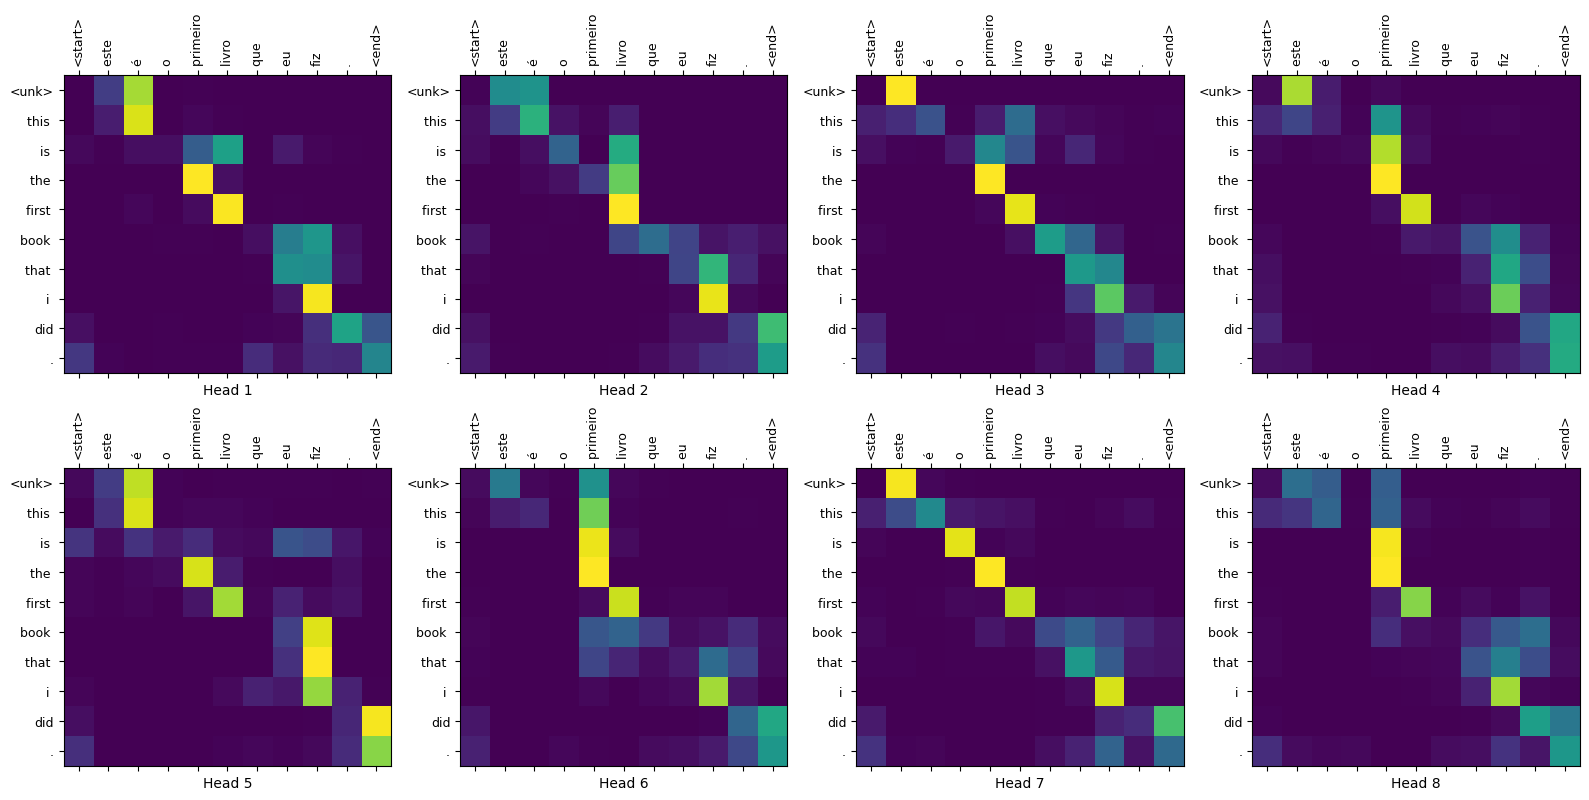

Real translation: this is the first book i've ever done.


In [112]:
translate("este é o primeiro livro que eu fiz.", plot='decoder_layer4_block2')
print ("Real translation: this is the first book i've ever done.")

## 总结

在本教程中，您已经学习了位置编码，多头注意力，遮挡的重要性以及如何创建一个 transformer。

尝试使用一个不同的数据集来训练 transformer。您可也可以通过修改上述的超参数来创建基础 transformer 或者 transformer XL。您也可以使用这里定义的层来创建 [BERT](https://arxiv.org/abs/1810.04805) 并训练最先进的模型。此外，您可以实现 beam search 得到更好的预测。